# Disease Classification
##### A Data Scientist Captone Project

### Main Analyis
In this script, I analyse the resultant data from the ETL process. The various analyses herein serve to investigate the main research objective staed in the blog titled Life or Death link here https://medium.com/@brian.meki/life-or-death-aaa8e42dac6b.

Below is a table of contents giving the structure of the Analyses process and how it is carried out.

### Table of Contents

I.      [Import Libraries and Define Custom Functions](#i-import-libraries-and-define-custom-libraries)<br>
II.     [Import Training and Testing Data](#ii-import-training-and-testing-data)<br>
III.    [Fit a Logistics Regression](#iii-fit-a-logistics-regression-model)<br>
IV.     [Evaluate the Logistics Regression Model](#iv-evaluate-the-logistics-regression-model)<br>
V.      [Fit a Decision Tree Model](#v-fit-a-decision-tree-model)<br>
VI.     [Evaluate the Decision Tree Model](#vi-evaluate-the-decision-tree-model)<br>
VII.    [Fit a 5-Fold Cross Validated Logistics Regression Model](#vii-fit-a-5-fold-cross-validated-logistics-regression-model)<br>
VIII.   [Fit a 5-Fold Cross Validated Decision Tree Model](#viii-fit-a-5-fold-cross-validated-decision-tree-model)<br>
IX.     [Compare All Model Performances](#ix-compare-all-model-performances)<br>

### <a class="anchor" id="i-import-libraries-and-define-custom-functions">I: Import Libraries and Define Custom Libraries</a>

In [2]:
# Import libraries
import random
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc 
import tabulate

# Define helper functions
# This function computes evalutation scores for fitted models
def evaluate_model(model, model_name, X_test, y_test, auc_score):

    # measure model accuracy
    mdl_accuracy = accuracy_score(y_pred = model.predict(X_test), y_true = y_test)
    
    # measure model recall
    mdl_recall = recall_score(y_pred = model.predict(X_test), y_true = y_test, average='weighted', zero_division=0)

    # measure model precision
    mdl_precision = precision_score(y_pred = model.predict(X_test), y_true = y_test, average='weighted', zero_division=0)
    
    # measure model f1- score
    mdl_f1 = f1_score(y_pred = model.predict(X_test), y_true = y_test, average='weighted', zero_division=0)

    # compile results into a dataframe
    scores_df = pd.DataFrame({'Score': ['Accuracy', 'Recall', 'Precision', 'F1_Score', 'AUC'],
                              model_name: [str(round(mdl_accuracy * 100, 2)) + '%', 
                                           str(round(mdl_recall * 100, 2)) + '%', 
                                           str(round(mdl_precision * 100, 2)) + '%', 
                                           str(round(mdl_f1 * 100, 2)) + '%',
                                           str(round(auc_score * 100, 2)) + '%']})

    return scores_df


### <a class="anchor" id="ii-import-training-and-testing-data">II: Import Training and Testing Data</a>

In [3]:
# Import training and testing data
train_data = pd.read_csv("Noisy_Disease_Training_Data.csv")
test_data = pd.read_csv("Clean_Disease_Testing_Data.csv")

# Define explanatory variables
X_train = pd.DataFrame(train_data).drop(columns=['prognosis'])
X_test = pd.DataFrame(test_data).drop(columns=['prognosis']) 
X_test = X_test.drop(columns=['row_index'])

# Define training and testing response variables
y_train = pd.DataFrame(train_data)['prognosis']
y_test = pd.DataFrame(test_data)['prognosis']

## Phase I
#### Fitting and Evaluating Standard Models

### <a class="anchor" id="iii-fit-a-logistics-regression-model">III: Fit a Logistics Regression Model</a>

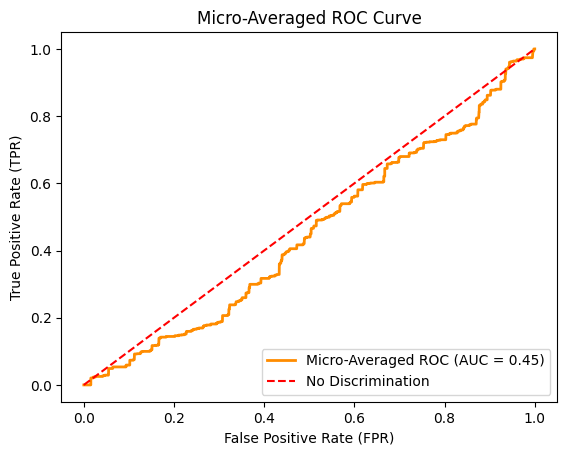

In [4]:

# Fit multiclass logistic regression model
logit_mdl = LogisticRegression(multi_class='ovr')
logit_mdl.fit(X_train, y_train)

# Compute decision function scores for each class
y_score = logit_mdl.decision_function(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(logit_mdl.classes_.size):
    fpr[i], tpr[i], _ = roc_curve(y_test == y_test.iloc[i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-averaged ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(logit_mdl.classes_.size)]))
mean_tpr = np.mean([np.interp(all_fpr, fpr[i], tpr[i]) for i in range(logit_mdl.classes_.size)], axis=0)
logit_mdl_auc = auc(all_fpr, mean_tpr)

logit_mdl_eval = evaluate_model(logit_mdl, 'Logistic_Regression', X_test, y_test, auc_score=logit_mdl_auc)

# Plot micro-averaged ROC curve
plt.figure()
plt.plot(all_fpr, mean_tpr, color='darkorange', lw=2, label=f'Micro-Averaged ROC (AUC = {logit_mdl_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='No Discrimination')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Micro-Averaged ROC Curve')
plt.legend(loc='lower right')
# save auc plot
plt.savefig("AUC of Standard Logistics Regression Model.png")
plt.show()


### <a class="anchor" id="iv-evaluate-the-logistics-regression-model">IV: Evaluate the Logistics Regression Model</a>

                 Feature  Importance
85       loss_of_balance    0.042197
34                nausea    0.031816
86          unsteadiness    0.026142
14               fatigue    0.025381
8                acidity    0.024917
..                   ...         ...
43     yellowing_of_eyes    0.001079
67               obesity    0.001070
93      internal_itching    0.000776
128   inflammatory_nails    0.000248
99   red_spots_over_body    0.000231

[132 rows x 2 columns]


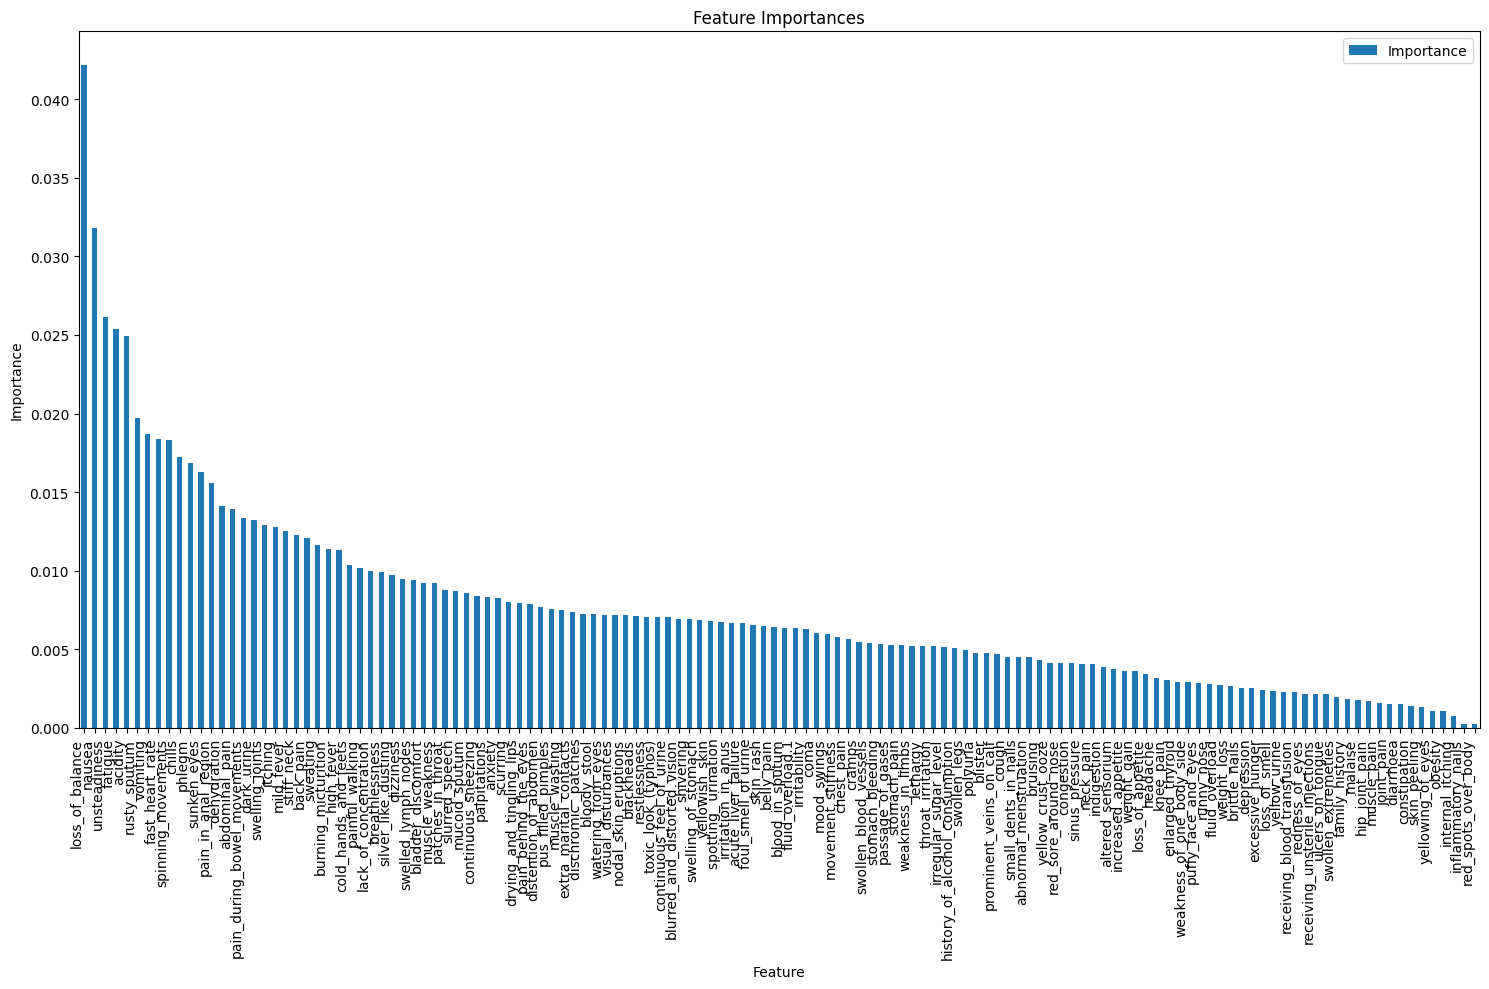

In [5]:
# Retrieve coefficients and feature names
coefficients = logit_mdl.coef_[0]
feature_names = X_train.columns

# Optionally, normalize coefficients
normalized_coefficients = coefficients / np.sum(np.abs(coefficients))
normalized_coefficients = np.abs(normalized_coefficients)
logit_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': normalized_coefficients
})

# Sort the DataFrame by importance values
logit_importance = logit_importance.sort_values(by='Importance', ascending=False)
print(logit_importance)

# Plot feature importances
(logit_importance).plot(kind="bar", x='Feature', y = 'Importance', figsize=(15, 10));
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
# save auc plot
plt.savefig("Feature Importance by Standard Logistics Regression Model.png")
plt.show()

### <a class="anchor" id="v-fit-a-decision-tree-model">V: Fit a Decision Tree Model</a>

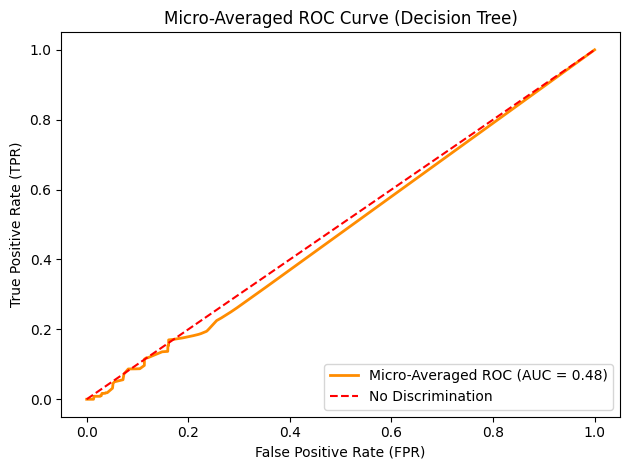

In [6]:
# Fit decision tree classifier model
dtree_mdl = DecisionTreeClassifier()
dtree_mdl.fit(X_train, y_train)

# Compute decision function scores for each class
y_score = dtree_mdl.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(dtree_mdl.classes_.size):
    fpr[i], tpr[i], _ = roc_curve(y_test == y_test.iloc[i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-averaged ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(dtree_mdl.classes_.size)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(dtree_mdl.classes_.size):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= dtree_mdl.classes_.size
dtree_mdl_auc = auc(all_fpr, mean_tpr)

dtree_mdl_eval = evaluate_model(dtree_mdl, 'Decision_Tree', X_test, y_test, auc_score=dtree_mdl_auc)

# Plot micro-averaged ROC curve
plt.figure()
plt.plot(all_fpr, mean_tpr, color='darkorange', lw=2, label=f'Micro-Averaged ROC (AUC = {dtree_mdl_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='No Discrimination')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Micro-Averaged ROC Curve (Decision Tree)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("AUC of a Standard Decision Tree Model.png")
plt.show()


### <a class="anchor" id="vi-evaluate-the-decision-tree-model">VI: Evaluate the Decision Tree Model</a>

                            Feature  Importance
25                       high_fever    0.043544
97                      muscle_pain    0.037401
88                    loss_of_smell    0.026938
22                patches_in_throat    0.026463
105                        polyuria    0.026054
..                              ...         ...
119         prominent_veins_on_calf    0.000135
112  receiving_unsterile_injections    0.000131
71                 enlarged_thyroid    0.000090
104              increased_appetite    0.000000
72                    brittle_nails    0.000000

[132 rows x 2 columns]


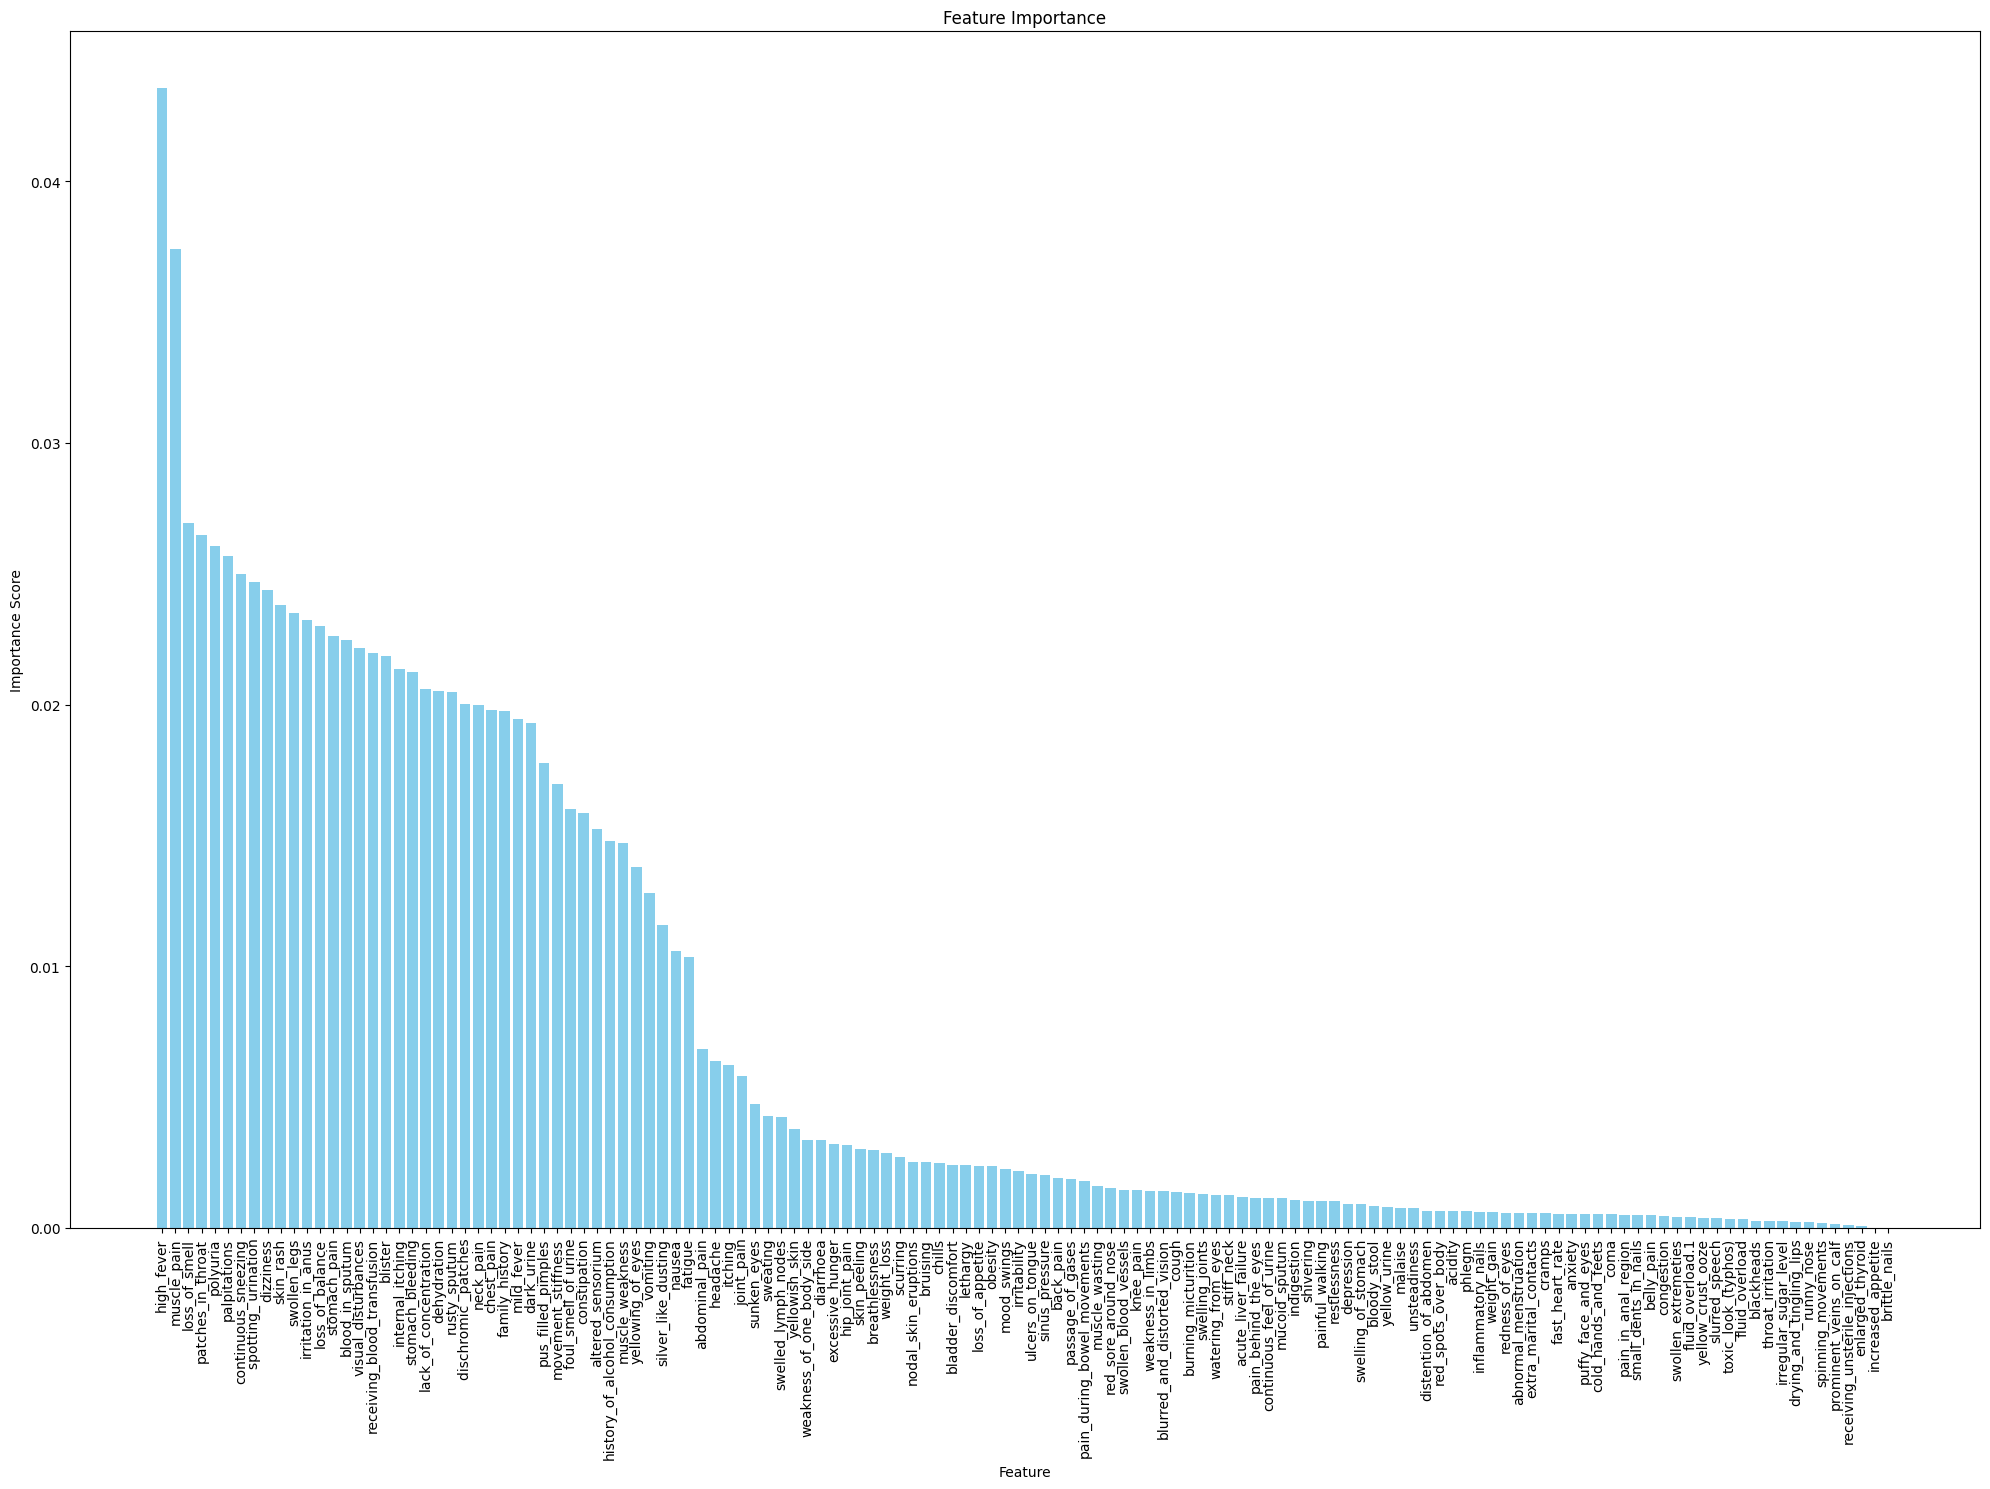

In [7]:
# Get feature importance scores from the trained decision tree model
feature_importance = dtree_mdl.feature_importances_

# Create a DataFrame to store feature names and their importance scores
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance
print(importance_df)

# Plot feature importance
plt.figure(figsize=(20, 15))
plt.bar(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importance')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
# save auc plot
plt.tight_layout()
plt.savefig("Feature Importance by Standard Decision Tree Model.png")
plt.show()

## Phase II: 
#### How To Improve Both Models Using n-Fold Cross Validation 

### <a class="anchor" id="vii-fit-a-5-fold-cross-validated-logistics-regression-model">VII: Fit a 5-Fold Cross Validated Logistics Regression Model</a>

c:\Users\brian.meki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan]
  warnings.warn(


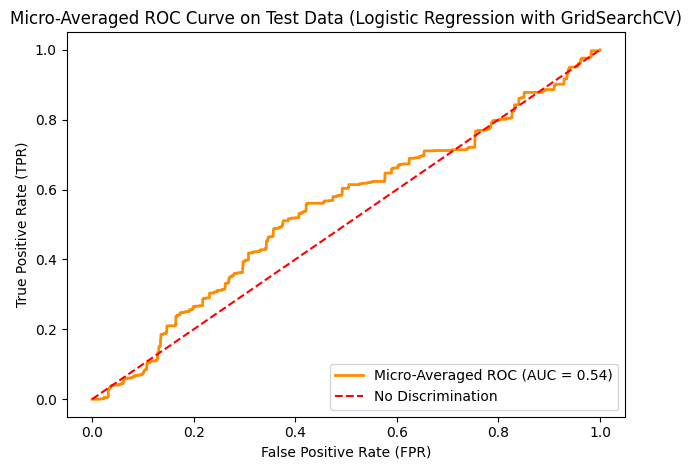

In [8]:
# Initialize logistic regression classifier model
logit_mdl = LogisticRegression(max_iter=1000, solver='liblinear')

# Define hyperparameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2']
}

# Define cross-validation strategy (Stratified K-Fold with 5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV object with logistic regression classifier and hyperparameter grid
grid_search = GridSearchCV(logit_mdl, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Perform hyperparameter tuning with GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_logit_mdl = grid_search.best_estimator_

# Compute predicted probabilities for test data using the best model
y_score_test = best_logit_mdl.predict_proba(X_test)

# Compute ROC curve and AUC for each class on test data
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
for i in range(best_logit_mdl.classes_.size):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test == y_test.iloc[i], y_score_test[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Compute micro-averaged ROC curve and AUC on test data
all_fpr_test = np.unique(np.concatenate([fpr_test[i] for i in range(best_logit_mdl.classes_.size)]))
mean_tpr_test = np.mean([np.interp(all_fpr_test, fpr_test[i], tpr_test[i]) for i in range(best_logit_mdl.classes_.size)], axis=0)
best_logit_mdl_auc = auc(all_fpr_test, mean_tpr_test)

best_logit_mdl_eval = evaluate_model(best_logit_mdl, 'Logistic_Regression_Cross_Validation', X_test, y_test, auc_score=best_logit_mdl_auc)

# Plot micro-averaged ROC curve on test data
plt.figure()
plt.plot(all_fpr_test, mean_tpr_test, color='darkorange', lw=2, label=f'Micro-Averaged ROC (AUC = {best_logit_mdl_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='No Discrimination')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Micro-Averaged ROC Curve on Test Data (Logistic Regression with GridSearchCV)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("AUC of a 5-Fold Cross Validated Logistics Regression Model.png")
plt.show()


### <a class="anchor" id="viii-fit-a-5-fold-cross-validated-decision-tree-model">VIII: Fit a 5-Fold Cross Validated Decision Tree Model</a>

c:\Users\brian.meki\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


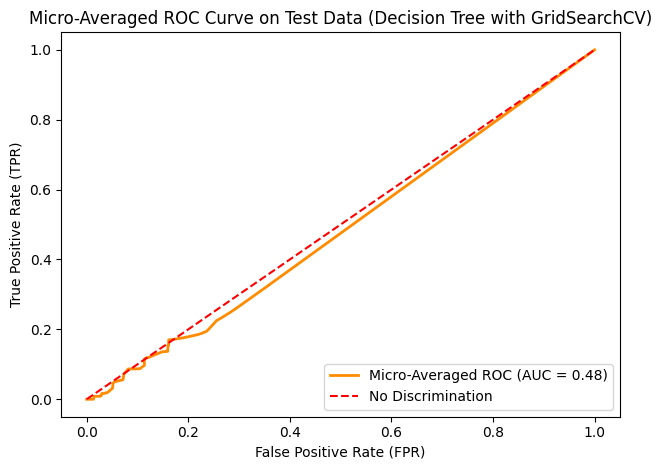

In [9]:
# Define hyperparameter grid for GridSearchCV
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define cross-validation strategy (Stratified K-Fold with 5 folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Create GridSearchCV object with decision tree classifier and hyperparameter grid
grid_search = GridSearchCV(dtree_mdl, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Perform hyperparameter tuning with GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_dtree_mdl = grid_search.best_estimator_

# Compute predicted probabilities for test data using the best model
y_score_test = best_dtree_mdl.predict_proba(X_test)

# Compute ROC curve and AUC for each class on test data
fpr_test = dict()
tpr_test = dict()
roc_auc_test = dict()
for i in range(best_dtree_mdl.classes_.size):
    fpr_test[i], tpr_test[i], _ = roc_curve(y_test == y_test.iloc[i], y_score_test[:, i])
    roc_auc_test[i] = auc(fpr_test[i], tpr_test[i])

# Compute micro-averaged ROC curve and AUC on test data
all_fpr_test = np.unique(np.concatenate([fpr_test[i] for i in range(best_dtree_mdl.classes_.size)]))
mean_tpr_test = np.mean([np.interp(all_fpr_test, fpr_test[i], tpr_test[i]) for i in range(best_dtree_mdl.classes_.size)], axis=0)
best_dtree_mdl_auc = auc(all_fpr_test, mean_tpr_test)

best_dtree_mdl_eval = evaluate_model(best_dtree_mdl, 'Decision_Tree_Cross_Validation', X_test, y_test, auc_score=best_dtree_mdl_auc)
 
# Plot micro-averaged ROC curve on test data
plt.figure()
plt.plot(all_fpr_test, mean_tpr_test, color='darkorange', lw=2, label=f'Micro-Averaged ROC (AUC = {best_dtree_mdl_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='No Discrimination')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Micro-Averaged ROC Curve on Test Data (Decision Tree with GridSearchCV)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("AUC of a 5-Fold Cross Validated Decision Tree Model.png")
plt.show()


### <a class="anchor" id="ix-compare-all-model-performances">IX: Compare All Model Performances</a>

In [10]:
# concurrently evaluate and compare model performance scores
compare_simple_mdls = pd.merge(logit_mdl_eval, dtree_mdl_eval,
                        on = 'Score')

# concurrently evaluate and compare model performance scores
compare_cv_mdls = pd.merge(best_logit_mdl_eval, best_dtree_mdl_eval,
                           on = 'Score')

# compare all models simultaneously
compare_all_mdls = pd.merge(compare_simple_mdls, compare_cv_mdls, on = 'Score')
compare_all_mdls_df = pd.DataFrame(compare_all_mdls)
print("******************************************************")
print(compare_all_mdls_df)
print("******************************************************")


******************************************************
       Score Logistic_Regression Decision_Tree  \
0   Accuracy              100.0%        91.84%   
1     Recall              100.0%        91.84%   
2  Precision              100.0%         93.1%   
3   F1_Score              100.0%        91.91%   
4        AUC              44.99%        48.26%   

  Logistic_Regression_Cross_Validation Decision_Tree_Cross_Validation  
0                                99.7%                         91.84%  
1                                99.7%                         91.84%  
2                               99.71%                          93.1%  
3                                99.7%                         91.91%  
4                               54.28%                         48.26%  
******************************************************


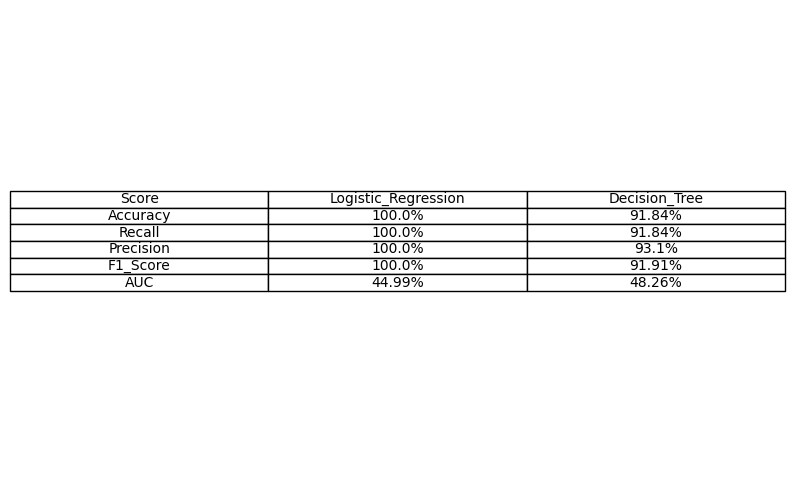

In [11]:
# Generate the table as a string using tabulate
table_str = tabulate.tabulate(compare_simple_mdls, headers=compare_simple_mdls.columns, tablefmt='plain', showindex=False)

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(10, 6))

# Remove the axes
ax.axis('off')

# Plot the table as text (excluding the first row)
table = ax.table(cellText=[row.split() for row in table_str.split('\n')[1:]], loc='center', cellLoc='center', colLabels=compare_simple_mdls.columns)

# Save the figure as a PNG file
plt.savefig('Compare_Standard_Model_Performances.png', bbox_inches='tight', pad_inches=0.1)


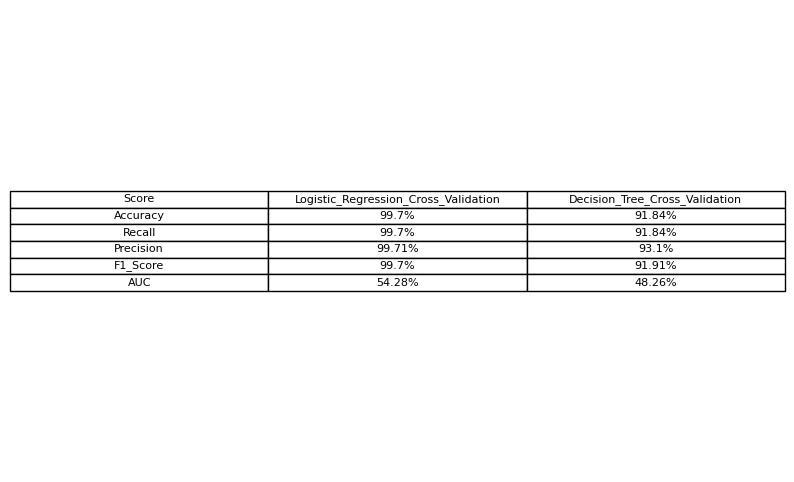

In [12]:
# Generate the table as a string using tabulate
table_str = tabulate.tabulate(compare_cv_mdls, headers=compare_cv_mdls.columns, tablefmt='plain', showindex=False)

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(10, 6))

# Remove the axes
ax.axis('off')

# Plot the table as text (excluding the first row)
table = ax.table(cellText=[row.split() for row in table_str.split('\n')[1:]], loc='center', cellLoc='center', colLabels=compare_cv_mdls.columns)

# Save the figure as a PNG file
plt.savefig('Compare_Fine_Tuned_Model_Performances.png', bbox_inches='tight', pad_inches=0.1)

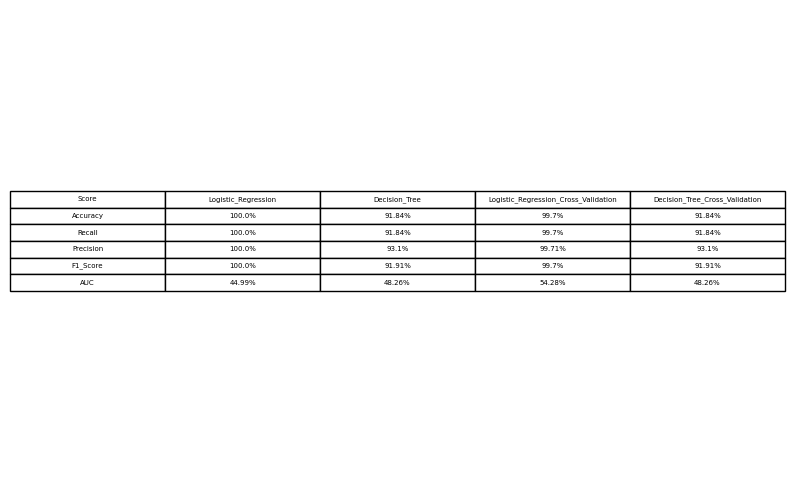

In [13]:
# Generate the table as a string using tabulate
table_str = tabulate.tabulate(compare_all_mdls, headers=compare_all_mdls.columns, tablefmt='plain', showindex=False)

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(10, 6))

# Remove the axes
ax.axis('off')

# Plot the table as text (excluding the first row)
table = ax.table(cellText=[row.split() for row in table_str.split('\n')[1:]], loc='center', cellLoc='center', colLabels=compare_all_mdls.columns)

# Save the figure as a PNG file
plt.savefig('Compare_Standard_Model_Performances.png', bbox_inches='tight', pad_inches=0.1)
